# Winter 2021 Shopify Data Science Intern Challenge

Provided here is an explanation of my thought process and reasoning while going through the questions provided by the job posting to arrive at my logical conclusions.

### Analysis of Shopify dataset

In [1]:
# Import required libraries
import pandas as pd

In [2]:
# Load the dataset and view it
data = pd.read_excel("Shopify_dataset.xlsx")
data

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190
1,2,92,925,90,1,cash,2017-03-03 17:38:51.999
2,3,44,861,144,1,cash,2017-03-14 04:23:55.595
3,4,18,935,156,1,credit_card,2017-03-26 12:43:36.649
4,5,18,883,156,1,credit_card,2017-03-01 04:35:10.773
...,...,...,...,...,...,...,...
4995,4996,73,993,330,2,debit,2017-03-30 13:47:16.597
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16.389
4997,4998,56,867,351,3,cash,2017-03-19 05:42:42.228
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18.188


AOV of $3145.13 was determined through initial analysis. <br>
Let us take a closer look at the dataset to determine why there is such a high AOV

In [3]:
aov_data = data[["total_items", "order_amount"]]
aov_data.groupby(["total_items"]).count()

,order_amount
total_items,
1,1830
2,1832
3,941
4,293
5,77
6,9
8,1
2000,17


All of the transaction sizes are 8 items or smaller, which follow reasoning, however we see 17 orders for 2000 items which appears odd. It's likely that these excessively large transactions are driving up the AOV. Let's inspect this further.

In [4]:
# Taking a look at orders with 2000 items, sorted by the date of the order
data[data["total_items"] == 2000].sort_values(by=["created_at"])

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 04:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00


From the above dataset, we can see that every recorded transaction for a item size of 2000 comes from used_id 607, ordering from shop_id 42 for a total of 704,000 every time. Moreover, we can see multiple repeated orders for the same time at the same day with purchases exactly at 4 AM. <br>
From this there are two conclusions that can be arrived at.
1. There is a glitch in the system causing there to be multiple repeated orders occuring whenever this particular transaction takes place, which should be looked into and fixed.
2. The buyer seems to have automated these transactions to occur exactly at 4 AM, to purchase a large amount of sneakers from the shop. This indicates some form of foul play and should be looked into further to ensure prooper action is taken

While we are at it, lets also take a look at the mean, minimum and maximum sales per item size

In [5]:
mmm = aov_data.groupby(["total_items"]).agg({'order_amount': 
                                       ['mean', 'min', 'max']})
mmm

order_amount                
                      mean     min     max
total_items                               
1               417.364481      90   25725
2               750.215066     180   51450
3              1191.076514     270   77175
4               947.686007     360  102900
5               759.350649     450    1760
6             17940.000000     774  154350
8              1064.000000    1064    1064
2000         704000.000000  704000  704000

From the above table, we see that there are some very large maximum orders placed for purchases of 1, 2, 3, 4, and 6 sneakers. Lets investigate these a little closer to see what can be gleaned from them.

In [6]:
mmm[('order_amount', 'max')]/[1, 2, 3, 4, 5, 6, 8, 2000]

total_items
1       25725.0
2       25725.0
3       25725.0
4       25725.0
5         352.0
6       25725.0
8         133.0
2000      352.0
Name: (order_amount, max), dtype: float64

When each of the maximum order amounts is divided by the total items bought in their respective transaction, we get a value of \\$25,725. It is safe to assume that an average pair of shoes would not cost \\$25,725, and therefore there is some recording mistake that occuring in the dataset.

Lets set up a scatter plot to see the general trend of the 5,000 orders that are on file

<AxesSubplot:xlabel='index', ylabel='order_amount'>

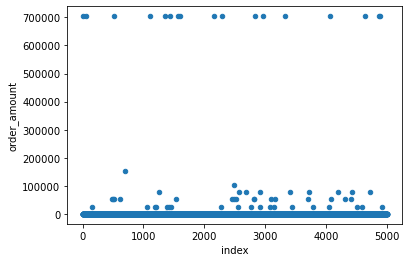

In [7]:
data.reset_index().plot.scatter(x='index', y='order_amount')

Here each point we see represents one transaction. <br>
From what we can see from the above scatter plot, a majority of the transactions are represented by the blue line seen towards the bottom, letting us know that most plausible orders are seen in the hundreds range, thousands maybe if it is a bulk order. <br>
Additionally, the row of dots near the top of the graph represent the multiple 2,000 orders of sneakers that was mentioned earlier.

Once this scatter plot is seen, it is fair to say that the initial evaluation metric, i.e. average order value (AOV), was poorly decided as it is affected greatly by the numerous extreme values seen in the dataset which have been previously mentioned. <br>
As a result, it would be better to choose a different evaluation metric to understand the dataset better. <br>
Hence, to protect the evaluation metric from the effects of the previously mentioned outliers it would be for the best to use a robust evaluation metric, such as the median, which will be found among the points in the dark blue line.

In [8]:
data['order_amount'].median()

284.0

## Question 1 Answers

### Question 1.a)
I do not think there is anything wrong with the calculation used to arrive at the Average Order Value (AOV). However, I think the issue lies within the dataset itself. When I took a quick look through the provided dataset, I noticed that there were a few orders noted down that seemed like definite outliers, which I feel were not considered when calculating the AOV, hence skewing the final value. For e.g., there seems to be multiple orders where 2000 items were purchased for \\$704,000, along with another order where an item was sold for \\$25,725. <br>
The first example consists of many sneakers being purchased, especially when compared to the standard 1-4 sneakers being sold on average in other transactions. Additionally, the second example consisted of an order for one sneaker at a considerably large price compared to the individual cost for each sneaker. <br>
Considering everything, I believe that if these values were removed the newly calculated AOV would be more along the lines of what is to be expected. <br>

### Question 1.b)
If given the choice, I would have chosen the median as an evaluation metric as it would prevent the effect of the outliers to influence the final result as much, as was explained above in the analysis. <br>
Furthermore, this value would have provided a more proper idea about the  price of sneakers being sold on the Shopify platform which allows for more business insights to be made rather than the AOV which does not explain much in terms of the transaction.<br>
This would also allow, new users that wish to sell sneakers on Shopify, to have an idea on where to price their own products in order to be competitive in the market.

### Question 1.c)
The median value is \\$284.00, which is a more reasonable value for the price for a single transaction purchase of one pair of sneakers.

## Question 2 Answers

### Question 2.a)
SELECT COUNT(*) FROM Shippers, Orders <br>
WHERE Shippers.ShipperID = Orders.ShipperID <br>
AND Shippers.ShipperName = 'Speedy Express'; <br>
    ANSWER: 54

### Question 2.b)
SELECT COUNT(*), Employees.LastName FROM Employees, Orders <br>
WHERE Employees.EmployeeID = Orders.EmployeeID <br>
GROUP BY Employees.LastName <br>
ORDER BY COUNT(*) DESC <br>
LIMIT 1; <br>
    ANSWER: 40     Peacock


### Question 2.c)
SELECT SUM(OrderDetails.Quantity), Products.ProductName FROM Customers, OrderDetails, Orders, Products <br>
WHERE Customers.Country = 'Germany' AND Customers.CustomerID = Orders.CustomerID AND Orders.OrderID = OrderDetails.OrderID AND  OrderDetails.ProductID = Products.ProductID <br>
GROUP BY Products.ProductName <br>
ORDER BY SUM(OrderDetails.Quantity) DESC <br>
LIMIT 1; <br>
    ANSWER: 160     Boston Crab Meat